In [6]:
############################################################
# FINAL SINDy PIPELINE — FIXED & CONSISTENT
############################################################

using NPZ
using LinearAlgebra
using Statistics
using ModelingToolkit
using OrdinaryDiffEq
using Printf

############################################################
# LOAD DATA
############################################################

data = npzread("data/processed/sstReducedState2COPERNICUS20102019.npz")

Z  = Float64.(data["Z"])    # (time, state)
dZ = Float64.(data["dZ"])
split = Int.(data["split"])

Z  = permutedims(Z)         # (state, time)
dZ = permutedims(dZ)

n_state, T = size(Z)

train_idx = findall(split .== 0)
test_idx  = findall(split .== 1)

Z_train  = Z[:, train_idx]
dZ_train = dZ[:, train_idx]

Z_test   = Z[:, test_idx]
dZ_test  = dZ[:, test_idx]

############################################################
# NORMALISATION (STATE-WISE)
############################################################

μ = mean(Z_train; dims=2)
σ = std(Z_train; dims=2) .+ 1e-8

Z_train_n = (Z_train .- μ) ./ σ
Z_test_n  = (Z_test  .- μ) ./ σ

dZ_train_n = dZ_train ./ σ
dZ_test_n  = dZ_test  ./ σ

############################################################
# SYMBOLIC VARIABLES
############################################################

@variables x[1:n_state]

############################################################
# LOCAL POLYNOMIAL LIBRARY
############################################################

basis = Num[]
push!(basis, 1)

# linear
for i in 1:n_state
    push!(basis, x[i])
end

# quadratic local
for i in 1:n_state
    push!(basis, x[i]^2)
    if i < n_state
        push!(basis, x[i] * x[i+1])
    end
end

nbasis = length(basis)
println("Reduced library size = ", nbasis)

############################################################
# BUILD Θ FUNCTION
############################################################

Θ_fun = ModelingToolkit.build_function(
    basis, x;
    expression = Val(false)
)[1]

############################################################
# BUILD Θ MATRICES
############################################################

function build_Θ(Zmat, Θ_fun, nbasis)
    Tloc = size(Zmat, 2)
    Θ = zeros(Float64, Tloc, nbasis)
    for t in 1:Tloc
        Θ[t, :] .= Θ_fun(Zmat[:, t])
    end
    return Θ
end

Θ_train = build_Θ(Z_train_n, Θ_fun, nbasis)
Θ_test  = build_Θ(Z_test_n,  Θ_fun, nbasis)

############################################################
# STLSQ (MANUAL)
############################################################

function stlsq(Θ, y; λ=0.1, n_iter=10)
    ξ = Θ \ y
    for _ in 1:n_iter
        small = abs.(ξ) .< λ
        ξ[small] .= 0.0
        big = .!small
        if any(big)
            ξ[big] = Θ[:, big] \ y
        end
    end
    return ξ
end

############################################################
# λ SWEEP
############################################################

λ_list = [0.05, 0.1, 0.2, 0.5]
results = Dict{Float64,Any}()

for λ in λ_list
    Ξ = zeros(Float64, nbasis, n_state)

    for i in 1:n_state
        Ξ[:, i] = stlsq(Θ_train, dZ_train_n[i, :]; λ=λ)
    end

    dZ_pred = (Θ_train * Ξ)'

    rmse_val = sqrt(mean((dZ_pred .- dZ_train_n).^2))
    sparsity = 100 * count(abs.(Ξ) .< 1e-12) / length(Ξ)

    results[λ] = (Ξ=Ξ, rmse=rmse_val, sparsity=sparsity)

    @printf "λ = %.2f | RMSE = %.4f | Sparsity = %.1f%%\n" λ rmse_val sparsity
end

############################################################
# BEST λ (NON-TRIVIAL)
############################################################

valid = filter(kv -> kv[2].sparsity < 99.9, results)
best_λ = argmin(k -> valid[k].rmse, keys(valid))
best = valid[best_λ]

println("\nBEST λ = ", best_λ)
println("RMSE = ", best.rmse)

Ξ = best.Ξ

############################################################
# DISPLAY EQUATIONS
############################################################

println("\nDiscovered equations (first 5 states):")

for i in 1:min(5, n_state)
    println("\ndx$i/dt =")
    for j in findall(abs.(Ξ[:, i]) .> 1e-8)
        println(@sprintf("  %+0.4f * %s", Ξ[j,i], basis[j]))
    end
end

############################################################
# TEST RMSE
############################################################

dZ_pred_test = (Θ_test * Ξ)'
rmse_test = sqrt(mean((dZ_pred_test .- dZ_test_n).^2))
println("\nTEST RMSE = ", rmse_test)

############################################################
# ODE ROLLOUT VALIDATION
############################################################

function sindy_rhs!(du, u, p, t)
    du .= (Θ_fun(u)' * Ξ)'[:]
end

u0 = Z_test_n[:, 1]
tspan = (0.0, size(Z_test_n,2)-1)

prob = ODEProblem(sindy_rhs!, u0, tspan)
sol = solve(prob, Tsit5(), saveat=1.0)

Z_rollout = hcat(sol.u...)
rollout_rmse = sqrt(mean((Z_rollout .- Z_test_n[:,1:size(Z_rollout,2)]).^2))

println("\nROLL-OUT RMSE = ", rollout_rmse)


Reduced library size = 51
λ = 0.05 | RMSE = 0.2750 | Sparsity = 32.2%
λ = 0.10 | RMSE = 0.2758 | Sparsity = 56.1%
λ = 0.20 | RMSE = 0.2792 | Sparsity = 96.4%
λ = 0.50 | RMSE = 0.2795 | Sparsity = 100.0%

BEST λ = 0.05
RMSE = 0.2749612899979503

Discovered equations (first 5 states):

dx1/dt =
  -0.1397 * x[1]
  +0.2348 * x[4]
  +0.1200 * x[7]
  -0.2529 * x[8]
  -0.1003 * x[10]
  +0.2457 * x[11]
  +0.1638 * x[12]
  +0.0603 * x[13]
  +0.0716 * x[14]
  -0.2557 * x[15]
  -0.2409 * x[16]
  +0.0973 * x[17]
  +0.0852 * x[1]^2
  +0.1921 * x[3]^2
  -0.4083 * x[3]*x[4]
  +0.3304 * x[4]*x[5]
  -0.2066 * x[5]^2
  +0.1679 * x[5]*x[6]
  -0.1396 * x[6]^2
  +0.2249 * x[7]^2
  -0.3043 * x[7]*x[8]
  +0.2956 * x[8]*x[9]
  -0.1546 * x[9]^2
  -0.0689 * x[10]*x[9]
  -0.5337 * x[11]^2
  +1.1110 * x[11]*x[12]
  -0.1648 * x[12]^2
  -0.7564 * x[12]*x[13]
  +0.1551 * x[13]^2
  +0.3810 * x[13]*x[14]
  -0.1184 * x[14]^2
  +0.1903 * x[15]^2
  -0.2227 * x[15]*x[16]
  +0.0827 * x[16]*x[17]
  -0.1376 * x[17]^2

dx2/dt

In [8]:
############################################################
# STABILIZED SINDy — SOLUTION A (GLOBAL DISSIPATION)
############################################################

using OrdinaryDiffEq
using Statistics
using Printf

############################################################
# DISSIPATION PARAMETER
############################################################

γ = 0.25         # ← valeur sûre (0.05–0.3 typiquement)

############################################################
# STABILIZED RHS
############################################################

function sindy_rhs_stable!(du, u, p, t)
    Θu = Θ_fun(u)                 # library evaluation
    du .= (Θu' * Ξ)'[:]           # SINDy prediction
    du .-= γ .* u                 # 🔑 global dissipation
end

############################################################
# ROLL-OUT VALIDATION
############################################################

u0 = Z_test_n[:, 1]
tspan = (0.0, length(test_idx)-1)

prob = ODEProblem(
    sindy_rhs_stable!,
    u0,
    tspan
)

sol = solve(
    prob,
    Tsit5(),
    saveat = 1.0,
    abstol = 1e-8,
    reltol = 1e-8
)

Z_rollout = hcat(sol.u...)

Tcmp = min(size(Z_rollout,2), size(Z_test_n,2))
rollout_rmse = sqrt(mean(
    (Z_rollout[:,1:Tcmp] .- Z_test_n[:,1:Tcmp]).^2
))

println("\nSTABILIZED ROLL-OUT RMSE = ", rollout_rmse)



STABILIZED ROLL-OUT RMSE = 0.8991818323818043


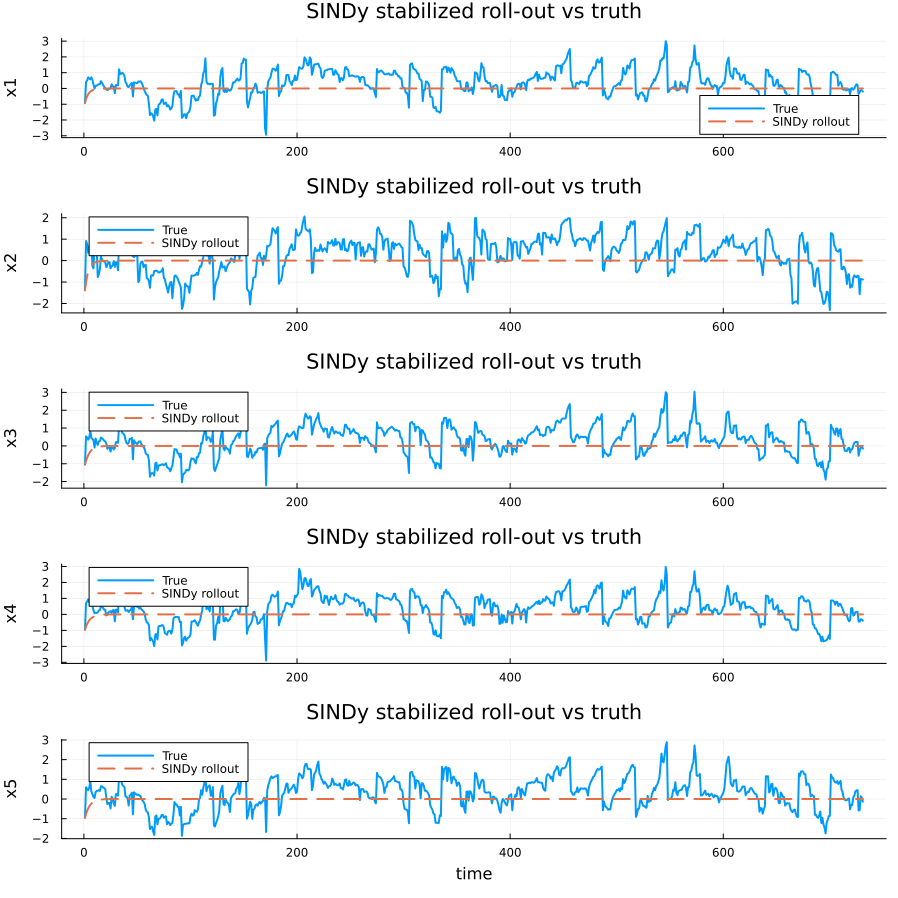

In [9]:
using Plots
gr()

modes_to_plot = 1:5
t = 1:size(Z_rollout, 2)

p = plot(layout=(length(modes_to_plot), 1), size=(900, 900))

for (k, i) in enumerate(modes_to_plot)
    plot!(
        p[k],
        t, Z_test_n[i, 1:length(t)],
        label="True",
        lw=2
    )
    plot!(
        p[k],
        t, Z_rollout[i, :],
        label="SINDy rollout",
        lw=2,
        ls=:dash
    )
    ylabel!(p[k], "x$i")
end

xlabel!(p[end], "time")
plot!(p, title="SINDy stabilized roll-out vs truth")
display(p)


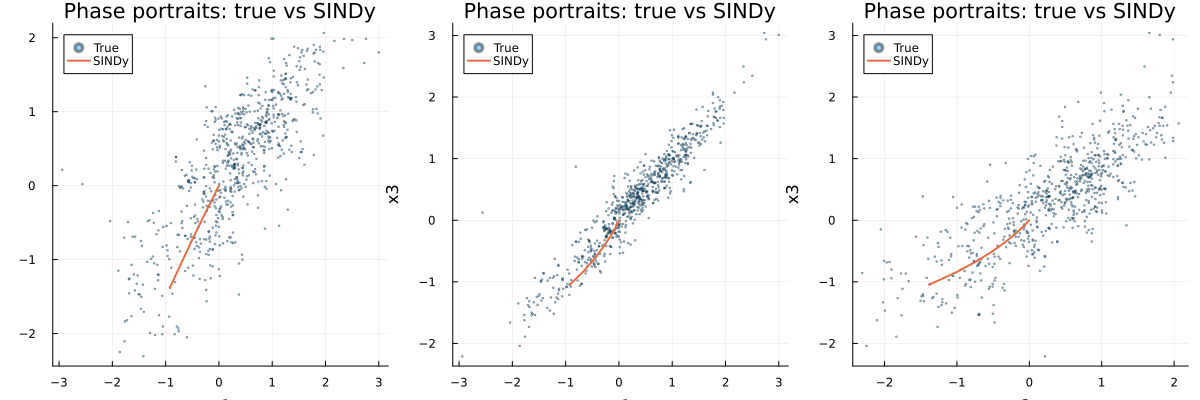

In [10]:
pairs = [(1,2), (1,3), (2,3)]

p = plot(layout=(1,3), size=(1200,400))

for (k, (i,j)) in enumerate(pairs)
    scatter!(
        p[k],
        Z_test_n[i, :], Z_test_n[j, :],
        ms=1,
        alpha=0.4,
        label="True"
    )
    plot!(
        p[k],
        Z_rollout[i, :], Z_rollout[j, :],
        lw=2,
        label="SINDy"
    )
    xlabel!(p[k], "x$i")
    ylabel!(p[k], "x$j")
end

plot!(p, title="Phase portraits: true vs SINDy")
display(p)


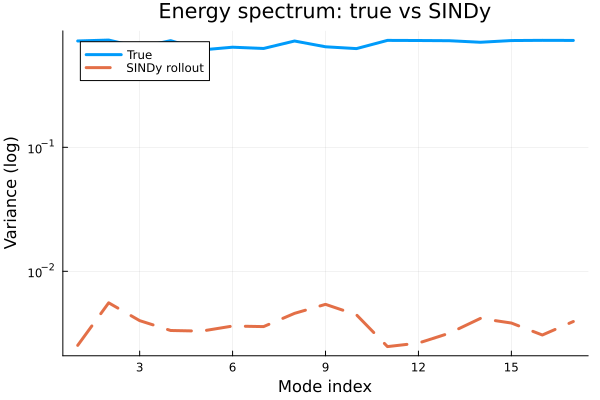

In [11]:
energy_true = var(Z_test_n; dims=2)[:]
energy_sindy = var(Z_rollout; dims=2)[:]

p = plot(
    energy_true,
    label="True",
    lw=3,
    yscale=:log10
)

plot!(
    p,
    energy_sindy,
    label="SINDy rollout",
    lw=3,
    ls=:dash
)

xlabel!("Mode index")
ylabel!("Variance (log)")
title!("Energy spectrum: true vs SINDy")
display(p)
